In [370]:
# !pip3 install imblearn
# !pip install -qU sagemaker
# !pip3 install xgboost 

In [407]:
import sys
import re
import os
import pathlib

from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='once')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Define Global Variables

In [372]:
OUTCOME = "total_cases"
DATA_PREFIX = r'/content/gdrive/MyDrive/Colab Notebooks/Mod5/data/'

    

# Utilities

In [373]:
def load_df(dataset):
    path = pathlib.Path(f"{DATA_PREFIX}dengue_{dataset}.csv")
    return pd.read_csv(path)

def save_csv(df, file_name):
    path = pathlib.Path(f"{DATA_PREFIX}{file_name}.csv")
    df.to_csv(path)

def get_cont_features(df):
    return list(filter(lambda col:\
                list(set(df[col].unique())) != [0,1] and\
                len(set(df[col].unique())) > 1, df.columns.tolist()
    ))

def get_predictors(cols, outcome):
    return [i for i in cols if i != outcome]

def format_label(feature):
    return feature.replace("_", " ").title()

def add_feature(df_main, file_name_to_add, on_feature):
    df_to_add = load_df(file_name_to_add)
    return df_main.merge(df_to_add, how="inner", on=on_feature)

def get_plot_ctx(df, cols, outcome):
    predictors = get_predictors(cols, outcome)
    col_num = 3
    row_num = math.ceil(len(predictors) / col_num)
    
    fig, axes = plt.subplots(row_num, col_num, figsize=(20, 60))
    axe = axes.ravel()
    return fig, axe, predictors
    
def drop_cols(df, cols):
    for col in cols:
        if col in df.columns.tolist():
            df.drop([col], axis=1, inplace=True)
            print(f"Column {col} removed.")
            

# Load data

We'll use the competition training dataset to build and validate our model, splitting it further into a training and testing subset.

In [374]:
def merge_datasets(file_name_0, file_name_1):
    df_0 = load_df(file_name_0)
    df_1 = load_df(file_name_1)
    df = df_0.merge(df_1, on=['city', 'year', 'weekofyear'])
    return df[ [OUTCOME] + [ col for col in df.columns if col != OUTCOME ] ]

df = merge_datasets("features_train", "labels_train")
df.head()

,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,4,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,5,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,4,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,6,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


### Preview outcome variable

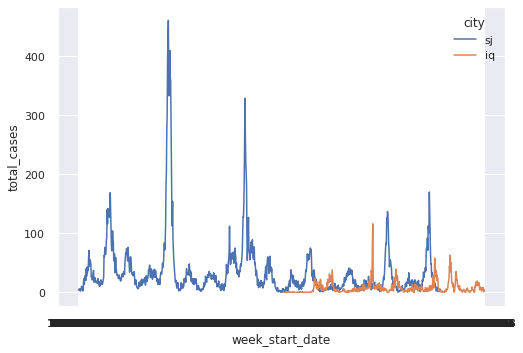

In [375]:
sns.set_theme(style="darkgrid")
sns.lineplot(x="week_start_date", y=OUTCOME, hue="city", data=df)


### Add outside features

Using domain knowledge

In [376]:
def add_elevation(df):
    df = add_feature(df, "elevation", "city")
    df['is_mountainous'] = df.apply(lambda row: 1 if row["elevation"] > 100 else 0, axis=1)
    df.drop(columns=['elevation'], axis=1, inplace=True)
    return df

df = add_elevation(df)
df.head(1)

,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous
0,4,sj,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,0


In [377]:
def add_climate_period(df):
    # 1998, 2014 https://history.aip.org/climate/timeline.htm
    df['pre_1998'] = np.where(df['year'] < 1998, 1, 0)
    
add_climate_period(df)
df.head()

,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous,pre_1998
0,4,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0,1
1,5,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,0,1
2,4,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,0,1
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,0,1
4,6,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,0,1


In [378]:
def add_seasons(df):
    wet = {
    'iq': [1,2,3,11,12],
    'sj': [4,5,6,7,8,9,10,11]
    }
    df['wet_season'] = df.apply(lambda row: 1 \
                            if int(row["week_start_date"].split("-")[1]) in wet[row.city]\
                            else 0,
                            axis=1)

add_seasons(df)
df.head()

,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous,pre_1998,wet_season
0,4,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0,1,1
1,5,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,0,1,1
2,4,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,0,1,1
3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,0,1,1
4,6,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,0,1,1


### Add composite key

In [379]:
# https://python.plainenglish.io/how-i-solved-the-dengue-fever-competition-question-using-adaboostingregressor-a9e82cb25f95

def consolidate_composite_key(df):
    df['composite_key'] = df.apply(lambda row: f"{row['city']}_{row['weekofyear']}_{row['year']}", axis=1)

consolidate_composite_key(df)
df.head(1)


,total_cases,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous,pre_1998,wet_season
0,4,sj,1990,18,1990-04-30,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.0,73.365714,12.42,14.012857,2.628571,25.442857,6.9,29.4,20.0,16.0,0,1,1


### Set the date as the index

In [380]:
# def date_to_index(df):
#     df.rename(columns={'week_start_date': 'date'}, inplace=True)
#     df['date'] = pd.to_datetime(df['date'])
#     df.set_index('date', inplace=True)

# date_to_index(df)
# df.head()

,total_cases,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous,pre_1998,wet_season
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,4,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,0,1,1
1990-05-07,5,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,0,1,1
1990-05-14,4,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,0,1,1
1990-05-21,3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,0,1,1
1990-05-28,6,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,0,1,1


### Standardize the data

In [405]:
def get_col_transformer():
    cont_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
    cat_transformer = make_pipeline(OrdinalEncoder())
    
    return ColumnTransformer(transformers=[
        ("cat", cat_transformer, make_column_selector(dtype_include="object")),
        ("cont", cont_transformer, make_column_selector(dtype_exclude="object")),
    ])

def standardize_data(df):
    drop_cols(df, ['city', 'year', 'weekofyear'])
    preprocessor = get_col_transformer()
    transformed = preprocessor.fit_transform(df)
    return pd.DataFrame(transformed, columns=df.columns, index=df.index)

df = standardize_data(df)
df.head(1)


,total_cases,ndvi_ne,ndvi_nw,ndvi_se,precipitation_amt_mm,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_sat_precip_amt_mm,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,pre_1998,wet_season
date,,,,,,,,,,,,,,,
1990-04-30,-0.482719,-0.11919,-0.204659,-0.037362,-0.808143,-1.936969,0.002664,-0.096381,-0.808143,-1.427445,-1.586318,-1.45202,-0.513315,1.558862,0.845592


### Consolidate data loading

In [408]:
def get_data():
    df = merge_datasets(f"features_train", f"labels_train")
    print(f"Raw data loaded. {df.shape[0]} rows. {df.shape[1]} features.\n\n\n")
    df = add_elevation(df)
    add_climate_period(df)
    add_seasons(df)
    consolidate_composite_key(df)
    # date_to_index(df)
    df = standardize_data(df)
    return df

df = get_data()
df.head()


Raw data loaded. 1456 rows. 25 features.



Column city removed.
Column year removed.
Column weekofyear removed.


,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,is_mountainous,pre_1998,wet_season,composite_key
0,0.0,664.0,-0.474407,-0.136768,-0.224959,-0.070729,-0.294221,-0.764739,-0.831532,-1.179965,-1.862076,-1.123029,0.069462,-0.186289,-1.232166,-0.764739,-1.780132,-0.639266,-1.374171,-0.541357,-1.571380,-1.342999,-0.490112,-0.745356,1.627613,0.856349
1,1.0,682.0,-0.451461,0.224679,0.101423,-0.563717,-0.560052,-0.525716,-0.361050,-0.623062,-0.852376,-0.781782,0.265082,-0.511127,-0.670635,-0.525716,-0.895242,-0.711966,-0.375608,-0.793046,-0.389200,0.061885,-0.647168,-0.745356,1.627613,0.856349
2,2.0,718.0,-0.474407,-0.827187,0.362797,-0.634092,-0.375586,-0.256355,0.058910,-0.276418,0.121666,-0.905872,0.617200,-0.322601,-0.013513,-0.256355,0.064938,-0.732160,-0.375608,-0.738627,-0.132205,0.445035,0.048974,-0.745356,1.627613,0.856349
3,3.0,736.0,-0.497353,-0.090664,0.974815,0.326020,0.405689,-0.697169,0.210475,0.002033,0.040026,-0.626670,0.499828,-0.604466,-0.254197,-0.697169,-0.049391,-0.695811,0.219042,-0.602579,0.433186,0.764326,-0.744798,-0.745356,1.627613,0.856349
4,4.0,754.0,-0.428515,0.425654,1.120251,0.648657,0.543275,-0.877355,0.602017,0.348677,0.375967,-0.471558,0.695449,-0.643742,-0.236962,-0.877355,0.300104,-0.530217,1.374682,0.635459,1.306971,1.147476,-0.706595,-0.745356,1.627613,0.856349


# Process the data

In [ ]:
def show_basic_correlations(df):
    cols = df.columns.tolist()
    fig, axe, predictors = get_plot_ctx(df, cols, OUTCOME)
    for i, col in enumerate(predictors):
        df.plot(kind='scatter', x=col, y=OUTCOME, alpha=0.4, color='b', ax=axe[i])
        axe[i].set_ylabel(format_label(OUTCOME))
        axe[i].set_xlabel(format_label(col))
        axe[i].set_title(f"Linearity check:\n{col} and {format_label(OUTCOME)}")
    plt.show()
    
NONLINEAR_COLS = [
    'reanalysis_air_temp_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_max_air_temp_k',
    'is_mountainous',
    'station_diur_temp_rng_c',
    'reanalysis_tdtr_k',
    'reanalysis_relative_humidity_percent',
    'ndvi_sw',
]
drop_cols(df, NONLINEAR_COLS)
show_basic_correlations(df)


### Assess multicolinearity


In [395]:
def get_collinear_pairs(df, outcome, t):
    i = 'index'
    corr_df = df.corr().reset_index()
    results = []
    cols = [col for col in corr_df.columns.tolist() if col not in [i, outcome]]
    for col in cols:
        over = corr_df[[i, col]].loc[(abs(corr_df[col]) > t) & (corr_df[i] != col), i]
        values = over.values
        if len(values) > 0:
            for value in values:
                pair = [value, col]
                pair.sort()
                results.append(f"{pair[0]} - {pair[1]}")
    results.sort()
    return list(set(results))

CORRELATED_PREDICTORS = [
  'is_mountainous',
  'is_sj',
  'reanalysis_max_air_temp_k',
  'station_diur_temp_rng_c',
  'reanalysis_avg_temp_k'
]

drop_cols(df, CORRELATED_PREDICTORS)
get_collinear_pairs(df, OUTCOME, t=0.8)


Column reanalysis_avg_temp_k removed.


['ndvi_ne - ndvi_nw', 'precipitation_amt_mm - reanalysis_sat_precip_amt_mm']

### Assess variance

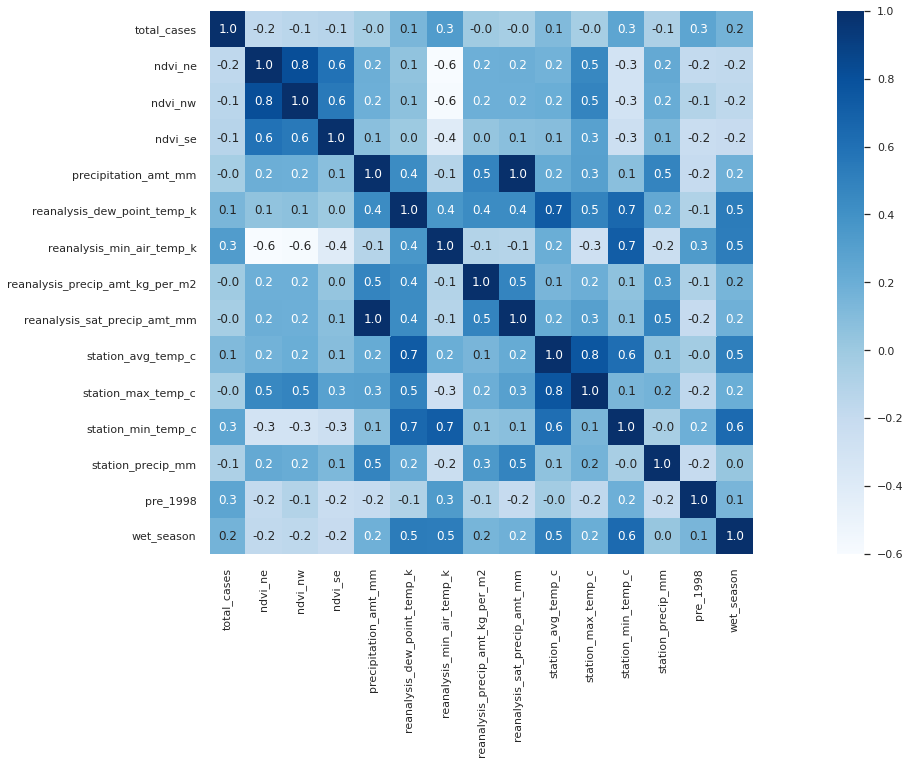

In [396]:
def generate_heat_map(df):
    plt.subplots(figsize=(30,10))
    corr = df.corr()
    sns.heatmap(corr, square=True, annot=True, fmt=".1f", cmap="Blues") 
    plt.show()

generate_heat_map(df)


### Test for outliers

Ndvi Ne: 7 row(s) removed.
Ndvi Nw: 4 row(s) removed.
Ndvi Se: 10 row(s) removed.
Precipitation Amt Mm: 17 row(s) removed.
Reanalysis Dew Point Temp K: 10 row(s) removed.
Reanalysis Min Air Temp K: 5 row(s) removed.
Reanalysis Precip Amt Kg Per M2: 31 row(s) removed.
Reanalysis Sat Precip Amt Mm: 11 row(s) removed.
Station Avg Temp C: 3 row(s) removed.
Station Max Temp C: 2 row(s) removed.
Station Min Temp C: 7 row(s) removed.
Station Precip Mm: 25 row(s) removed.
.
.
_____

132 total rows removed. 1324 rows remaining.


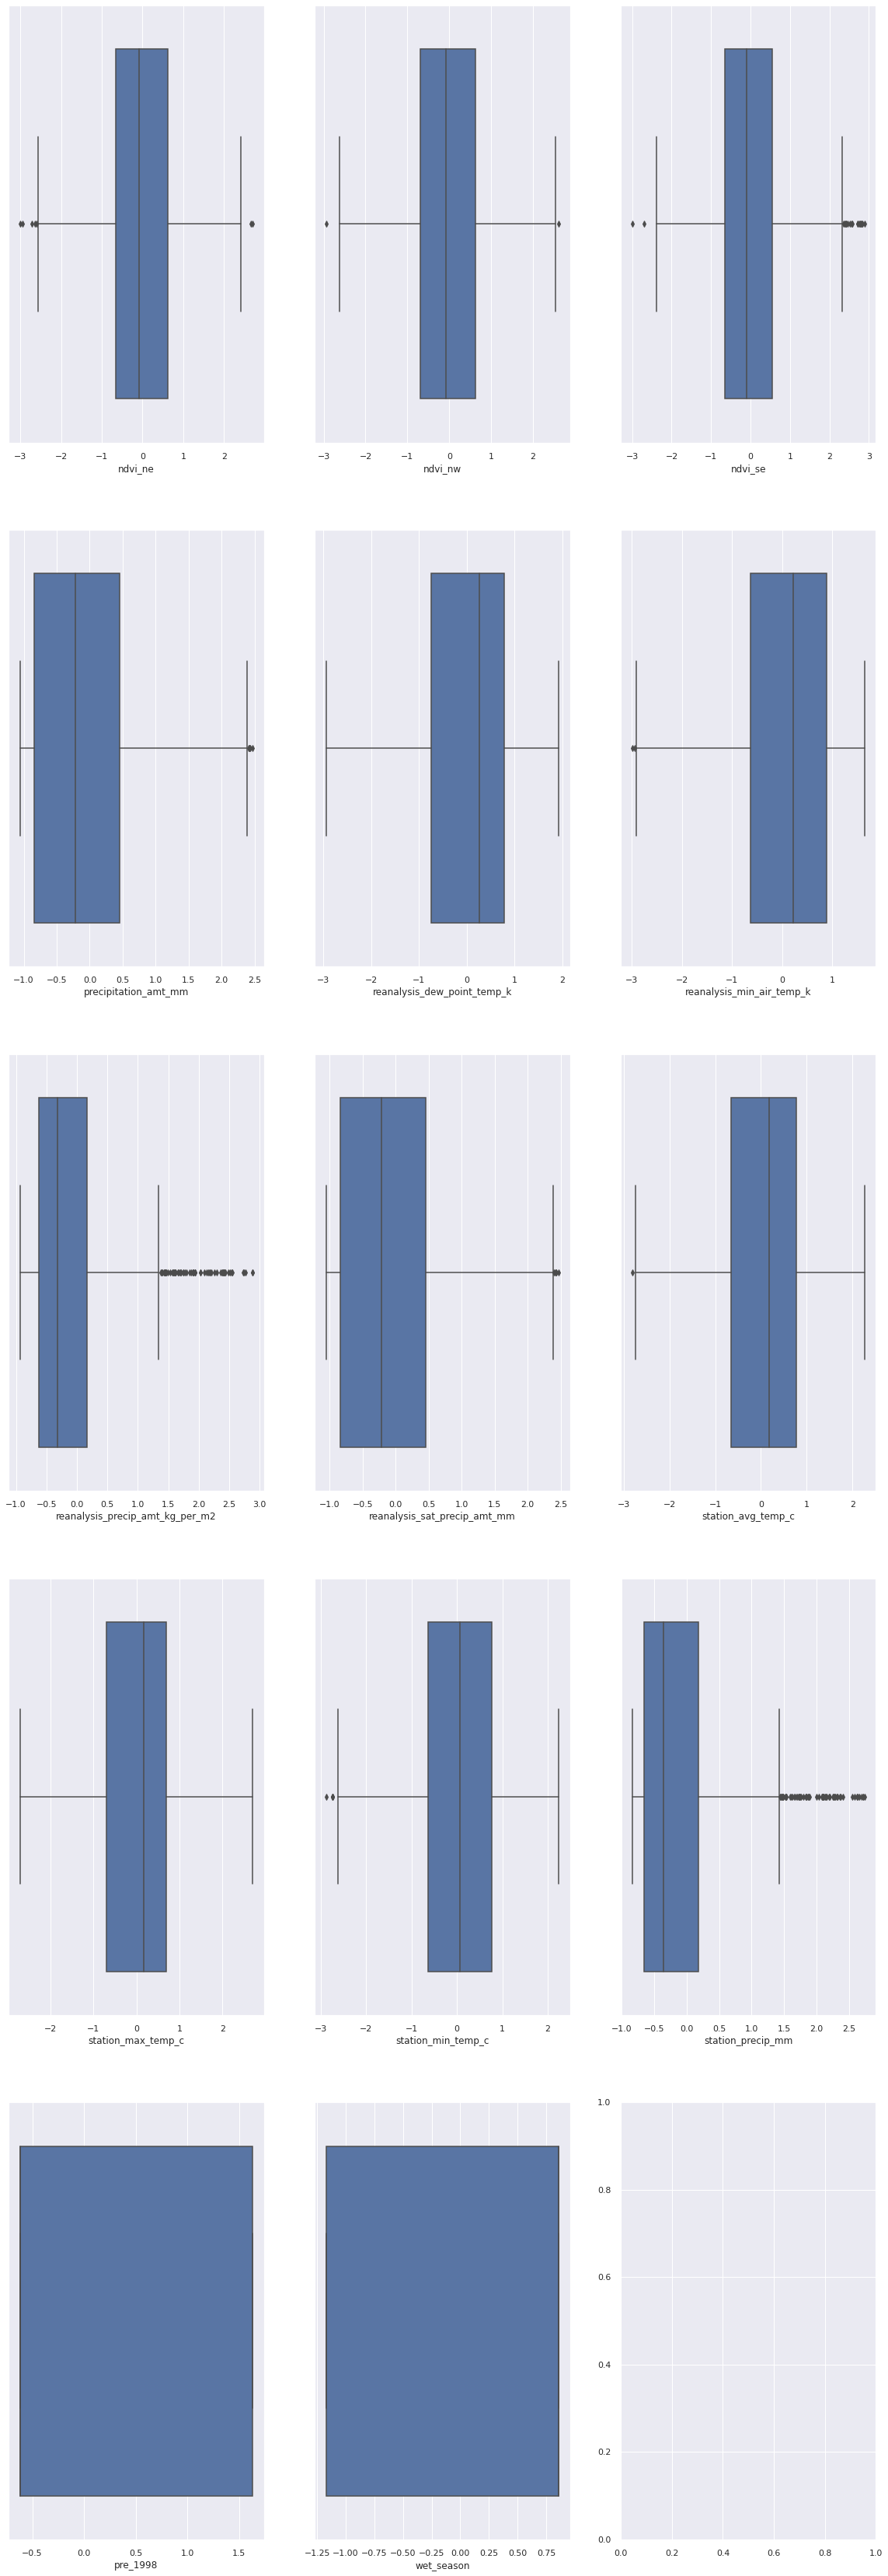

In [397]:
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

def show_outliers(df, outcome):
    cols = get_cont_features(df)
    fig, axe, predictors = get_plot_ctx(df, cols, outcome)

    for i, xcol in enumerate(predictors):
        sns.boxplot(x=df[xcol], ax=axe[i])
    plt.show()
    
def remove_outliers(df, outcome):
    cols = [i for i in get_cont_features(df) if i != outcome]
    rows_0 = df.shape[0]
    for col in cols:
        data = df[col]
        data_mean, data_std = mean(data), std(data)
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        
        outliers = [x for x in data if x < lower or x > upper]
        if len(outliers) > 0:
            cnt_0 = df.shape[0]
            df = df.loc[(df[col] >= lower)]
            df = df.loc[(df[col] <= upper)]
            cnt_1 = df.shape[0]
            print(f"{format_label(col)}: {cnt_0 - cnt_1} row(s) removed.")
        else:
            print(f".")
            pass
    rows_1 = df.shape[0]
    print(f"_____\n\n{rows_0 - rows_1} total rows removed. {rows_1} rows remaining.")
    return df

df = remove_outliers(df, OUTCOME)
show_outliers(df, OUTCOME)



Linear regression assumes a normal distribution and equal variance . Before using linear regression, we need to assess whether or not it is an appropriate choice for our dataset.

In the below, we see fairly equal variance across our features.

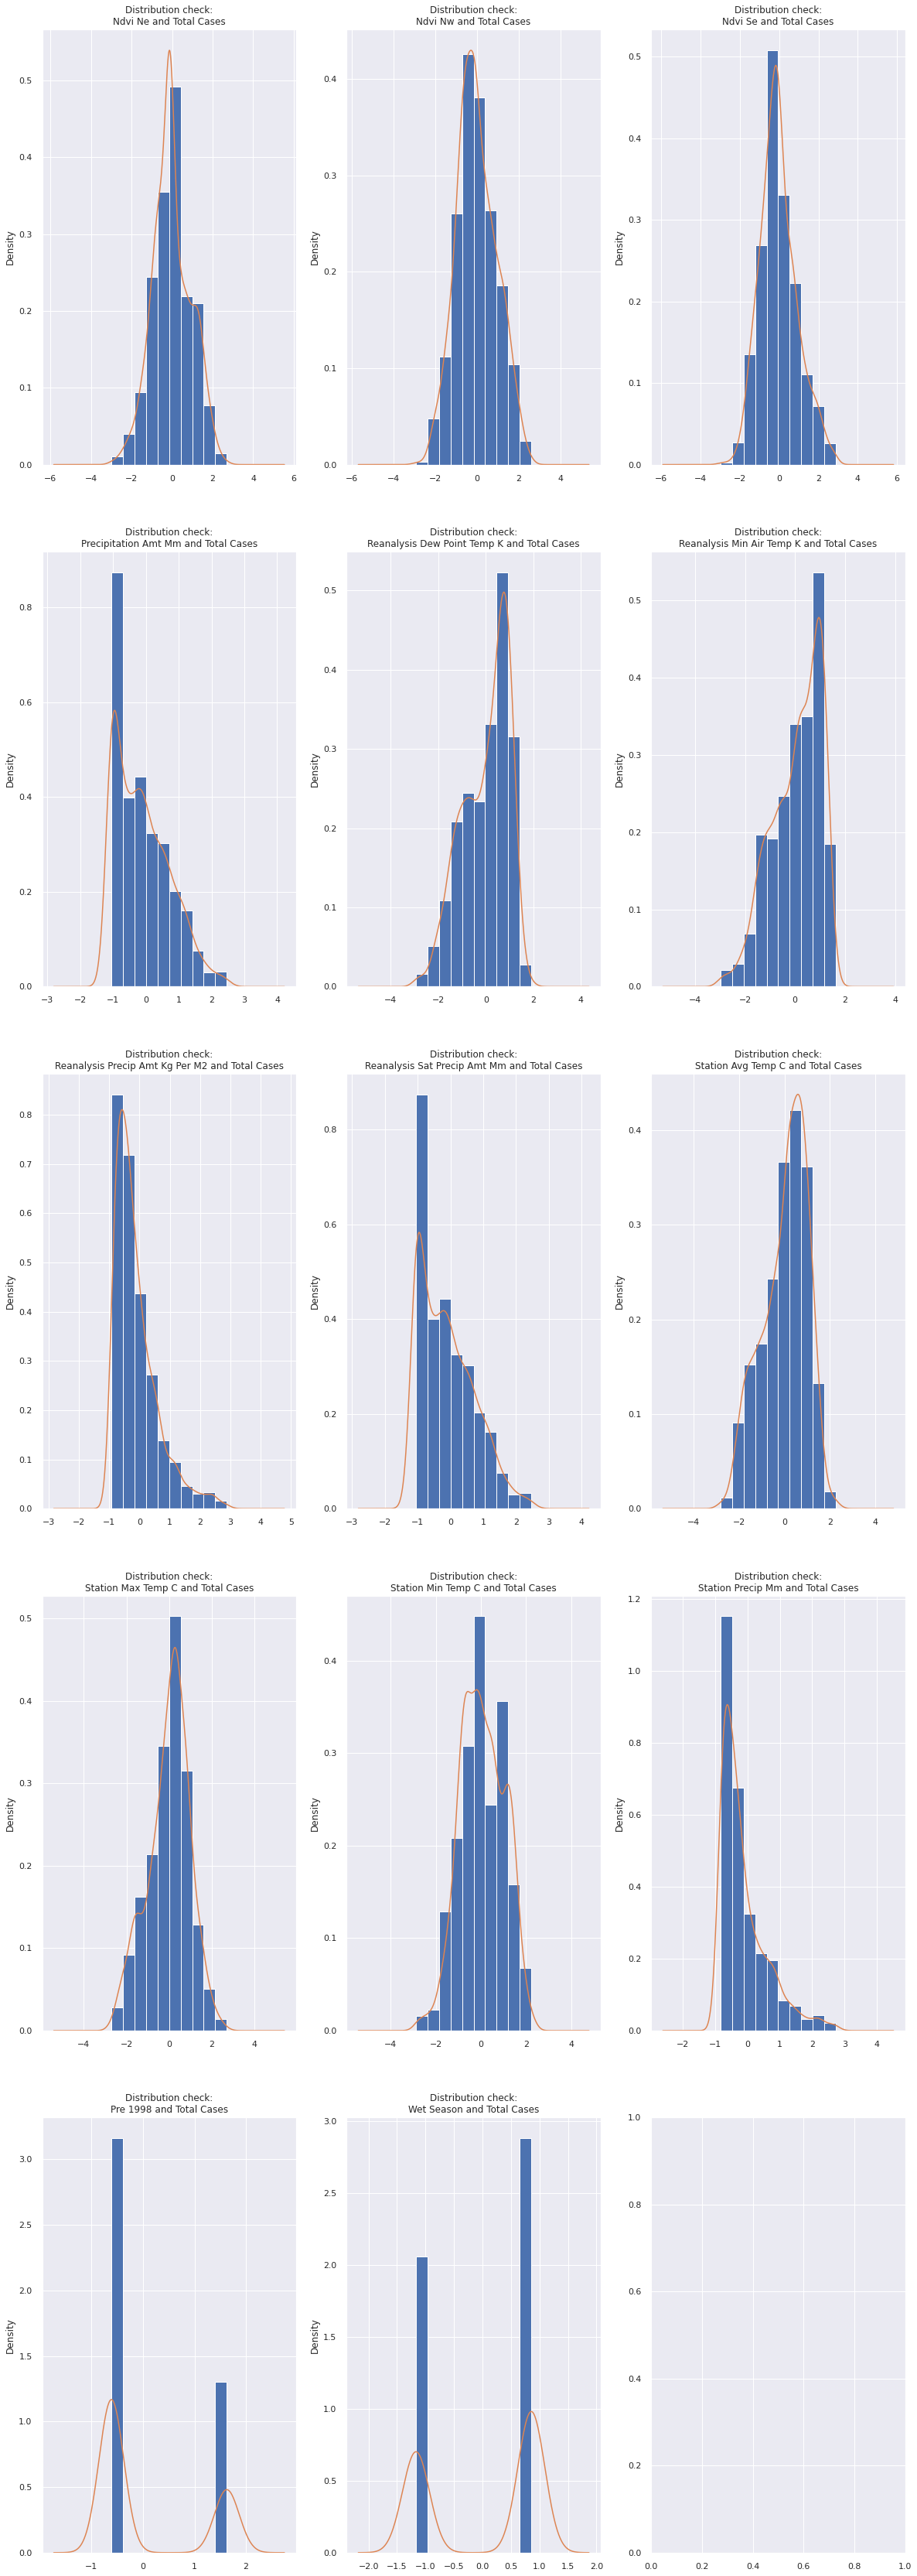

In [398]:
# http://68.183.140.86:57267/notebooks/dsc-regression-assumptions-online-ds-sp-000/index.ipynb
# https://github.com/learn-co-curriculum/dsc-ols-statsmodels-lab/tree/solution
  
def show_kernel_density(df):
    cols = get_cont_features(df)
    fig, axe, predictors = get_plot_ctx(df, cols, OUTCOME)
    
    for i, col in enumerate(predictors):
        df[col].plot.hist(density=True, label=col+' histogram', ax=axe[i])
        df[col].plot.kde(label=col+' kde', ax=axe[i])
        axe[i].set_title(f"Distribution check:\n{format_label(col)} and {format_label(OUTCOME)}")
    plt.show()

show_kernel_density(df)


### Consolidate data cleaning

In [ ]:
def get_processed_data():
    print("Loading data...")
    
    df = get_data()
    
    print("\n\nCleaning data...\n\n")
    drop_cols(df, NONLINEAR_COLS)
    drop_cols(df, CORRELATED_PREDICTORS)
    df = remove_outliers(df, OUTCOME)
    
    print(f"\n\nData cleaning completed: {df.shape[0]} records and {df.shape[1]} features remaining.")
    
    return df


df_ = get_processed_data()   
df.head()

# Build the model

In [ ]:
def get_transformed_data():
    df = get_processed_data()
    y = df[[OUTCOME]]
    X = df.drop([OUTCOME], axis=1)

    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_transformed_data()


In [410]:
linreg = LinearRegression().fit(X_train, y_train)
print('Training r^2:', linreg.score(X_train, y_train))
print('Training MSE:', mean_squared_error(y_train, linreg.predict(X_train)))
print('\nTest r^2:', linreg.score(X_test, y_test))
print('Test MSE:', mean_squared_error(y_test, linreg.predict(X_test)))


Training r^2: 0.7699539441839106
Training MSE: 18323.160442200216

Test r^2: 0.7845384630889551
Test MSE: 16495.750115061906


In [411]:
grad_boost = GradientBoostingRegressor().fit(X_train, y_train)
print('Training r^2:', grad_boost.score(X_train, y_train))
print('Training MSE:', mean_squared_error(y_train, grad_boost.predict(X_train)))
print('\nTest r^2:', grad_boost.score(X_test, y_test))
print('Test MSE:', mean_squared_error(y_test, grad_boost.predict(X_test)))


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training r^2: 0.8918698378757148
Training MSE: 8612.563698237625

Test r^2: 0.8362112930373062
Test MSE: 12539.674693034256


In [412]:
ada_boost = AdaBoostRegressor(random_state=0, n_estimators=100).fit(X_train, y_train)
print('Training r^2:', ada_boost.score(X_train, y_train))
print('Training MSE:', mean_squared_error(y_train, ada_boost.predict(X_train)))
print('\nTest r^2:', ada_boost.score(X_test, y_test))
print('Test MSE:', mean_squared_error(y_test, ada_boost.predict(X_test)))


Training r^2: 0.7953737905273885
Training MSE: 16298.470554276279

Test r^2: 0.7878229777140348
Test MSE: 16244.287449004021


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
